# **DASA CS-2: [TAS: Tele Assistance System]**

In [1]:
# -*- coding: utf-8 -*-
# Native imports
import os
import re
import sys
import time

# Third-party imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# for plotting refined dimensionless chart
from matplotlib.colors import LinearSegmentedColormap
from scipy.stats import binned_statistic_2d
import matplotlib.ticker as ticker

# PyDASA imports
# config module
from src.pydasa.utils import config
# FDU modules
from src.pydasa.core.fundamental import Dimension
# FDU regex management
from src.pydasa.dimensional.framework import DimScheme
# Variable and Variable modules
from src.pydasa.core.parameter import Variable
# Dimensional Matrix Modelling module
from src.pydasa.dimensional.model import DimMatrix
# sensitivity analysis modules
from src.pydasa.analysis.scenario import DimSensitivity
from src.pydasa.handlers.influence import SensitivityHandler
# Monte Carlo Simulation modules
from src.pydasa.analysis.simulation import MonteCarloSim
from src.pydasa.handlers.practical import MonteCarloHandler

## **Project Overview**

- TAS offers telehealth services to patients at home.
- It uses third-party services for medical analysis, emergency alarms, and drug delivery.
- Self-adaptation deals with uncertainty (changing service quality, patient needs).
- The system uses runtime models, simulations, and a MAPE-K feedback loop (ActivFORMS runtime environment) to adapt proactively​

## **Software Architecture Summary**

### **Base Design**
Service-oriented architecture (SOA) + MAPE-K feedback loop
- **Service-oriented architecture (SOA):** Each Comp is a service that can be replaced or reconfigured.
- **MAPE-K feedback loop:** Monitors the system, analyzes its state, plans adaptations, and executes them based on knowledge stored in the Knowledge Base.

Dividing TAS into Target and Controller Parts (MAPE-K Structure)

| Subsystem | Comps |
|:---|:---|
| **Target System (Managed System)** | - **TAS Core Services:** Vital Parameters Monitor, Medication Management, Emergency Response Trigger <br> - **Service Integrations:** Medical Analysis Services (MAS), Alarm Services (AS), Drug Services (DS) from third-party providers <br> - **Probes:** Instruments to collect data about vital signs, service invocations, failures, and latencies <br> - **Effectors:** Mechanisms to replace or reconfigure services dynamically |
| **Controller (Managing System)** | - **Monitor:** Observes system state, updates runtime models (service failures, delays, costs) <br> - **Analyzer:** Runs simulations (runtime statistical model checking) on updated models to predict system qualities <br> - **Planner:** Selects best service configuration based on goals (availability, performance, cost) <br> - **Executor:** Applies adaptations (switches services, reconfigures workflows) <br> - **Knowledge Base:** Maintains models of the system, environment models, adaptation goals, quality models |

Reference: Based on MAPE-K division and ActivFORMS architecture.

### **Notes**
- TAS (Tele Assistance System) operates in a dynamic environment where service quality, availability, and user needs frequently change.
- It implements **self-adaptive mechanisms** using the MAPE-K feedback loop.
- Adaptation is critical to maintaining **reliability**, **performance**, and **compliance** with patient care standards.
- ActivFORMS provides the runtime framework for model-based adaptation using runtime models, simulations, and verified decision-making.
---

### **Functional Requirements (Reported Capabilities)**

| ID | Description |
|:-----|:---|
| RC-001 | Provide remote health support for patients with chronic conditions within their homes. |
| RC-002 | Periodically measure patients' vital signs using wearable devices and sensors. |
| RC-003 | Analyze patient data using third-party medical analysis services to assess health status. |
| RC-004 | Invoke pharmacy services to deliver medication if analysis indicates a treatment change is needed. |
| RC-005 | Adjust medication dosage dynamically based on updated health analysis. |
| RC-006 | Send automatic alarms and alerts to emergency services during critical situations. |
| RC-007 | Dynamically integrate new third-party services into existing workflows to enhance system functionality. |
| RC-008 | Adapt to changing healthcare goals by modifying workflows and service selections in real-time. |
| RC-009 | Ensure system reliability by switching to equivalent services when current ones fail or degrade. |
| RC-010 | Continuously monitor service performance and adjust workflows to optimize reliability, performance, and cost. |

---

### **Quality Scenarios (QS)**

| ID | Quality Attribute | Sub-Category | Scenario Description |
|:-----|:---|:---|:---|
| QS-001 | Availability | Fault Tolerance | TAS must detect third-party service failures and switch to a backup service within 30 seconds. |
| QS-002 | Performance | Response Time | TAS must process health analysis results and issue alerts within 2.5 seconds. |
| QS-003 | Interoperability | Syntactic/Semantic | TAS must successfully integrate new third-party services dynamically without downtime. |
| QS-004 | Usability | Learnability | Patients must access and understand health data via the TAS interface within 5 minutes of onboarding. |
| QS-005 | Security | Confidentiality | Patient data must be encrypted during transmission and storage, ensuring HIPAA compliance. |
| QS-006 | Adaptability | Dynamic Reconfiguration | TAS must reconfigure workflows dynamically based on real-time patient data and healthcare goals. |

---

### **Adaptation Scenarios (AS)**

| ID | Scenario | Description | Adaptation Strategy |
|:-------|:---|:---|:---|
| AS-001 | Service Failure | A third-party service fails to respond, impacting TAS operations. | Switch to an equivalent service; use redundancy (invoke multiple services simultaneously if needed). |
| AS-002 | Variation in Service Response Time | A third-party service exceeds expected response times, degrading TAS performance. | Switch to a more performant service; prioritize services based on real-time response metrics. |
| AS-003 | New Service Introduction | A new third-party service becomes available. | Dynamically recognize and integrate new services into the registry and workflows. |
| AS-004 | Changing Goals | Healthcare objectives or patient needs change over time. | Adjust workflows and select appropriate services to meet updated goals. |
| AS-005 | Wrong Operation Sequence | Errors or inefficiencies in workflow execution. | Redesign and reconfigure the workflow sequence to ensure compliance with functional requirements. |

---

#### **FDU (Fundamental Design Unit)**

In [2]:
# setting up custom FDU for software architecture
tas_fwk = "SOFTWARE"
tas_scm = DimScheme(_sym="FDU_{TAS}",
                        _alias="fdu_tas",
                        _idx=0,
                        name="TAS FDUs",
                        _fwk=tas_fwk,
                        description="FDU schema for the TAS case study.")
# print(tas_scm)
print("=== TAS Fundamental Dimenional Unit (FDU) Schema ===")
for dim in tas_scm.fdus:
    print(f"\t'{dim.sym}': {dim.name}, [{dim.unit}]")

=== TAS Fundamental Dimenional Unit (FDU) Schema ===
	'T': Time, [s]
	'D': Data, [bit]
	'E': Effort, [req]
	'C': Connectivity, [node]
	'A': Capacity, [process]


In [3]:
tas_scm.update_global_config()
print("\n==== Checking Schema Regex ====")
print("\tWKNG_DFLT_FDU_PREC_LT:", config.WKNG_FDU_PREC_LT)
print("\tWKNG_FDU_RE:", config.WKNG_FDU_RE)
print("\tWKNG_POW_RE:", config.WKNG_POW_RE)
print("\tWKNG_NO_POW_RE:", config.WKNG_NO_POW_RE)
print("\tWKNG_FDU_SYM_RE:", config.WKNG_FDU_SYM_RE)


==== Checking Schema Regex ====
	WKNG_DFLT_FDU_PREC_LT: ['T', 'D', 'E', 'C', 'A']
	WKNG_FDU_RE: ^[TDECA](\^-?\d+)?(\*[TDECA](?:\^-?\d+)?)*$
	WKNG_POW_RE: \-?\d+
	WKNG_NO_POW_RE: [TDECA](?!\^)
	WKNG_FDU_SYM_RE: [TDECA]


#### **Dimensional Variables**

Based on the QN (Queue Network) model for the component + sequenece diagrams

<!-- ![Diagram description](./images/diagram.svg) -->
<img src="./assets/img/CS-01-Health TAS/04A - Queue Network.svg"  width="1200" alt="TAS queue network component diagram" style="display: block; margin: auto;">
<!-- <img src="./images/tas_architecture.svg" width="800" alt="TAS queue network component diagram" style="display: block; margin: auto;"> -->


In [4]:
# list of variables
# all components use the queue model M/M/1/K
# arrival rate => lambda, IN, independent
# departure rate => chi/x, IN, dependent
# service rate => miu, IN, independent
# request in queue => n, CTRL ~ < 60%*K
# requests in service/servers => c, IN
# mean service time => S, OUT, dependant
# mean queue time => Q, OUT, dependant
# mean response time => W = Q + S, OUT, independent
# mean queue size => L = λ * W, OUT, dependant
# max queue size => K, independent

print("\n==== Variables ====")
# dict with variables
tas_vars ={
    # C1 -> TAS (Tele Assistance Service) 1
    # C1 = C2 = C3 = C10 = C12 = C13
    # C1 = TAS_1
    # λ1=344.83 [req/s], Χ1=344.83 [req/s], μ1=1000.00 [req/s]
    "\\lambda_{1}": Variable(_sym="\\lambda_{1}",
                                   _alias="lambda_tas_1",
                                   _fwk="SOFTWARE",
                                   name="TAS component 1 arrival 1",
                                   description="TAS arrival rate 1",
                                   relevant=True,
                                   _idx=0,
                                   _cat="IN",
                                   _units="req/s",
                                   _dims="E*T^-1",
                                   _min=0.0,
                                   _max=344.83,
                                   _mean=344.83,
                                   _std_units="req/s",
                                   _std_min=0.0,
                                   _std_max=344.83,
                                   _std_mean=344.83,
                                   _dist_type="exponential",
                                   _dist_params={"scale": 1/344.83},
                                   _dist_func=lambda: np.random.exponential(1/344.83)),
    "\\miu_{1}": Variable(_sym="\\miu_{1}",
                                   _alias="miu_tas_1",
                                   _fwk="SOFTWARE",
                                   name="TAS component 1 service rate",
                                   description="TAS service rate 1",
                                   relevant=True,
                                   _idx=1,
                                _cat="CTRL",
                                   _units="req/s",
                                   _dims="E*T^-1",
                                   _min=0.0,
                                   _max=1000.0,
                                   _mean=1000.0,
                                   _std_units="req/s",
                                   _std_min=0.0,
                                   _std_max=1000.0,
                                   _std_mean=1000.0,
                                   _dist_type="exponential",
                                   _dist_params={"scale": 1/1000},
                                   _dist_func=lambda: np.random.exponential(1/1000)),
    "K_{1}": Variable(_sym="K_{1}",
                             _alias="k_1",
                             _fwk="SOFTWARE",
                             name="TAS component 1 max queue size",
                             description="TAS max queue size 1",
                             relevant=True,
                             _idx=3,
                             _cat="IN",
                             _units="req",
                             _dims="E",
                             _min=99.9,
                             _max=100.1,
                             _mean=100.0,
                             _std_units="req",
                             _std_min=99.9,
                             _std_max=100.1,
                             _std_mean=100.0,
                             _dist_type="uniform",
                             _dist_params={"constant": 100},
                             _dist_func=lambda: 100),
    "n_{1}": Variable(_sym="n_{1}",
                             _alias="n_1",
                             _fwk="SOFTWARE",
                             name="TAS component 1 requests in queue",
                             description="TAS requests in queue 1",
                             relevant=True,
                             _idx=2,
                             _cat="IN",
                             _units="req",
                             _dims="E",
                             _min=0.0,
                             _max=60.0,
                             _mean=30.0,
                             _std_units="req",
                             _std_min=0.0,
                             _std_max=60.0,
                             _std_mean=30.0,
                             _dist_type="uniform",
                             _dist_params={"low": 0, "high": 60},
                             _dist_func=lambda: np.random.uniform(0, 60)),
    "W_{1}": Variable(_sym="W_{1}",
                             _alias="w_1",
                             _fwk="SOFTWARE",
                             name="TAS component 1 response time",
                             description="TAS response time 1",
                             relevant=True,
                             _idx=4,
                             _cat="OUT",
                             _units="s/req",
                             _dims="T*E^-1",
                             _min=0.0,
                             _max=60.0,
                             _mean=30.0,
                             _std_units="s/req",
                             _std_min=0.0,
                             _std_max=60.0,
                             _std_mean=30.0,
                             _dist_type="uniform",
                             _dist_params={"low": 0, "high": 60},
                             _dist_func=lambda: np.random.uniform(0, 60)),
    "L_{1}": Variable(_sym="L_{1}",
                             _alias="l_1",
                             _fwk="SOFTWARE",
                             name="TAS component 1 latency",
                             description="TAS latency 1",
                             relevant=True,
                             _idx=5,
                            _cat="CTRL",
                             _units="req",
                             _dims="E",
                             _min=0.0,
                             _max=60.0,
                             _mean=30.0,
                             _std_units="req",
                             _std_min=0.0,
                             _std_max=60.0,
                             _std_mean=30.0,
                             _dist_type="uniform",
                             _dist_params={"low": 0, "high": 60},
                             _dist_func=lambda: np.random.uniform(0, 60)),
    # # C2 = TAS_2
    # # λ2=258.62 [req/s], Χ2=258.62 [req/s], μ2=1000.00 [req/s]
    # "C_{TAS_{2}}": Variable(),
    # # C3 = TAS_3
    # # λ3=174.14 [req/s], Χ3=174.14 [req/s], μ3=1000.00 [req/s]
    # "C_{TAS_{3}}": Variable(),
    # # C4, C5, C6 -> MAS (Medical Assistance Service)
    # # C4 = MAS_1
    # # λ4=88.17 [req/s], Χ4=77.59 [req/s], μ4=180.00 [req/s]
    # "C_{MAS_{1}}": Variable(),
    # # C5 = MAS_2
    # # λ5=132.09 [req/s], Χ5=122.84 [req/s], μ5=530.00 [req/s]
    # "C_{MAS_{2}}": Variable(),
    # # C6 = MAS_3
    # # λ6=70.96 [req/s], Χ6=58.19 [req/s], μ6=150.00 [req/s]
    # "C_{MAS_{3}}": Variable(),
    # # C7, C8, C9 -> AS (Alarm Service)
    # # C7 = AS_1
    # # λ7=65.22 [req/s], Χ7=58.05 [req/s], μ7=700.00 [req/s]
    # "C_{AS_{1}}": Variable(),
    # # C8 = AS_2
    # # λ8=60.46 [req/s], Χ8=58.05 [req/s], μ8=410.00 [req/s]
    # "C_{AS_{2}}": Variable(),
    # # C9 = AS_3
    # # λ9=70.79 [req/s], Χ9=58.05 [req/s], μ9=1580.00 [req/s]
    # "C_{AS_{3}}": Variable(),
    # # C10 = TAS_4
    # # λ10=60.46 [req/s], Χ10=58.05 [req/s], μ10=410.00 [req/s]
    # "C_{TAS_{4}}": Variable(),
    # # C11 -> DS (Drug Service)
    # # C11 = DS_1
    # # λ11=179.67 [req/s], Χ11=183.62 [req/s], μ11=550.00 [req/s]
    # "C_{DS_{1}}": Variable(),
    # # C12 = TAS_5
    # # λ12=174.14 [req/s], Χ12=174.14 [req/s], μ12=1000.00 [req/s]
    # "C_{TAS_{5}}": Variable(),
    # # C13 = TAS_6
    # # λ13=170.69 [req/s], Χ13=174.44 [req/s], μ13=1000.00 [req/s]
    # "C_{TAS_{6}}": Variable(),
}





"""
C Vs. Metric	λi [req/s]	Χi [req/s]	μi [req/s]
*C1	                344.83	344.83	1000.00
*C2	                258.62	258.62	1000.00
*C3	                174.14	174.14	1000.00
C4	                88.17	77.59	180.00
C5	                132.09	122.84	530.00
C6	                70.96	58.19	150.00
C7	                65.22	58.05	700.00
C8	                60.46	58.05	410.00
C9	                70.79	58.05	1580.00
*C10	            258.62	258.62	1000.00
C11	                179.67	183.62	550.00
*C12	            174.14	174.14	1000.00
*C13	            170.69	174.44	1000.00
Sum	                157.57	153.94	776.92

Avg for all C1-C13	λi [req/s]	Χi [req/s]	μi [req/s]
f(M/M/1/∞/FIFO)	f(M/M/1/∞/FIFO)
Li [req]	Wi [s*req^(-1)]
2.333E+00	2.020E-02


"""


for i, var in enumerate(tas_vars.values()):
    var.idx = i
    print(f"Variable {var.idx}: '{var.sym}', ({var.cat})")
    print(f"\tStd Units: '{var.std_units}'")
    print(f"\tDimensionality: '{var.dims}'")



==== Variables ====
Variable 0: '\lambda_{1}', (IN)
	Std Units: 'req/s'
	Dimensionality: 'E*T^-1'
Variable 1: '\miu_{1}', (CTRL)
	Std Units: 'req/s'
	Dimensionality: 'E*T^-1'
Variable 2: 'K_{1}', (IN)
	Std Units: 'req'
	Dimensionality: 'E'
Variable 3: 'n_{1}', (IN)
	Std Units: 'req'
	Dimensionality: 'E'
Variable 4: 'W_{1}', (OUT)
	Std Units: 's/req'
	Dimensionality: 'T*E^-1'
Variable 5: 'L_{1}', (CTRL)
	Std Units: 'req'
	Dimensionality: 'E'


#### **Dimensionl Model**

In [5]:
tas_model = DimMatrix(_fwk="SOFTWARE",
                    _idx=0,
                    _framework=tas_scm)
tas_model.variables = tas_vars
print("Setting parameters for the dimensional analysis")
print(len(tas_model.variables), tas_model.variables.keys(), "\n")

tas_model.relevant_lt = tas_vars
print("Setting the relevance list for dimensional analysis")
print(len(tas_model.relevant_lt), tas_model.relevant_lt.keys(), "\n")

# print(tas_model, "\n")
# print(tas_model.working_fdus, "\n")

Setting parameters for the dimensional analysis
6 dict_keys(['\\lambda_{1}', '\\miu_{1}', 'K_{1}', 'n_{1}', 'W_{1}', 'L_{1}']) 

Setting the relevance list for dimensional analysis
6 dict_keys(['\\lambda_{1}', 'K_{1}', 'n_{1}', 'W_{1}', '\\miu_{1}', 'L_{1}']) 



In [6]:
# solving dimensional problem
tas_model.create_matrix()
tas_model.solve_matrix()

print(tas_model._pivot_cols, "\n")
print(tas_model, "\n")

[0, 1] 

DimMatrix(sym='', alias='', fwk='SOFTWARE', idx=0, name='Dimensional Matrix', description='', framework=DimScheme(_sym='FDU_{TAS}', _alias='fdu_tas', _fwk='SOFTWARE', _idx=0, name='TAS FDUs', description='Fdu schema for the tas case study.', _fdus=[Dimension(_sym='T', _alias='', _fwk='SOFTWARE', _idx=0, name='Time', description='Duration of an event or interval.', _unit='s'), Dimension(_sym='D', _alias='', _fwk='SOFTWARE', _idx=1, name='Data', description='Information processed by a system.', _unit='bit'), Dimension(_sym='E', _alias='', _fwk='SOFTWARE', _idx=2, name='Effort', description='Measure of computational effort/complexity.', _unit='req'), Dimension(_sym='C', _alias='', _fwk='SOFTWARE', _idx=3, name='Connectivity', description='Measure of interconnections between components.', _unit='node'), Dimension(_sym='A', _alias='', _fwk='SOFTWARE', _idx=4, name='Capacity', description='Maximum amount of data that can be stored/processed.', _unit='process')], _fdu_map={'T': Dimen

#### **Dimensionless Coefficients**

In [7]:
for k, v in tas_model.coefficients.items():
    pi = v
    print(f"Coefficient: {k} = {pi._pi_expr}")

Coefficient: \Pi_{0} = \frac{n_{1}}{K_{1}}
Coefficient: \Pi_{1} = \lambda_{1}*W_{1}
Coefficient: \Pi_{2} = \frac{\miu_{1}}{\lambda_{1}}
Coefficient: \Pi_{3} = \frac{L_{1}}{K_{1}}


#### **Sensitivity Analysis**

In [8]:
tas_sena = SensitivityHandler(_idx=0,
                              _sym="SA_{TAS_{0}}",
                              _fwk="SOFTWARE",
                              name="Sensitivity Analysis TAS No 1",
                              description="Sensitivity Analysis for TAS 1",
                              _variables=tas_vars,
                              _coefficients=tas_model._coefficients,)

In [9]:
for k, v in tas_sena.coefficients.items():
    pi = v
    print(f"Coefficient: {k} = {pi._pi_expr}")

Coefficient: \Pi_{0} = \frac{n_{1}}{K_{1}}
Coefficient: \Pi_{1} = \lambda_{1}*W_{1}
Coefficient: \Pi_{2} = \frac{\miu_{1}}{\lambda_{1}}
Coefficient: \Pi_{3} = \frac{L_{1}}{K_{1}}


In [10]:
print("=== Sym Analysis: ===")
tas_sena.analyze_symbolic(val_type="mean")

for k, v in tas_sena.results.items():
    print(f"{k}: {v}")
# print(tas_sena.results, "\n")

print("\n=== Num Analysis: ===")
tas_sena.analyze_numeric(n_samples=50000)

for k, v in tas_sena.results.items():
    print(f"{k}: {v}")
    for a, b in v.items():
        print(f"\t{a}: {b}")

print("Sensitivity Analysis Results:")
# print(tas_sena.analyses, "\n")

for key, val in tas_sena.results.items():
    txt = f"{key}: {val}"
    print(txt)

=== Sym Analysis: ===
SEN_{\Pi_{0}}: {'K_{1}': -0.003, 'n_{1}': 0.01}
SEN_{\Pi_{1}}: {'W_{1}': 344.83, '\\lambda_{1}': 30.0}
SEN_{\Pi_{2}}: {'\\lambda_{1}': -0.008409882261236259, '\\miu_{1}': 0.0028999797001420993}
SEN_{\Pi_{3}}: {'K_{1}': -0.003, 'L_{1}': 0.01}

=== Num Analysis: ===
SEN_{\Pi_{0}}: {'S1': [0.004534573874684294, 0.00012325498888611768], 'ST': [0.8755362920926699, 0.7077667516287656], 'S1_conf': [0.0002592584274825621, 0.00023578719941655358], 'ST_conf': [0.013654252591888743, 0.0032130803608464297], 'names': ['K_{1}', 'n_{1}']}
	S1: [0.004534573874684294, 0.00012325498888611768]
	ST: [0.8755362920926699, 0.7077667516287656]
	S1_conf: [0.0002592584274825621, 0.00023578719941655358]
	ST_conf: [0.013654252591888743, 0.0032130803608464297]
	names: ['K_{1}', 'n_{1}']
SEN_{\Pi_{1}}: {'S1': [0.4276278118588545, 0.4276411564841299], 'ST': [0.5713869722649849, 0.5713735973066669], 'S1_conf': [0.0002787390537237643, 0.0002848603357568771], 'ST_conf': [0.005375906295936562, 0.00

#### **Monte Carlo Simulation**

In [11]:
print("\n=== monte carlo handler ===")
# Create a handler
tas_mch = MonteCarloHandler(_sym="MCH_{0}",
                            _fwk="SOFTWARE",
                            name="TAS Monte Carlo Handler",
                            description="TAS Monte Carlo Handler for simulations",
                            _variables=tas_model.relevant_lt,
                            _coefficients=tas_model.coefficients)
print(tas_mch, "\n")


=== monte carlo handler ===
MonteCarloHandler(sym='MCH_{0}', alias='MCH_0', fwk='SOFTWARE', idx=-1, name='TAS Monte Carlo Handler', description='Tas monte carlo handler for simulations', cat='NUM', variables={'\\lambda_{1}': Variable(_sym='\\lambda_{1}', _alias='lambda_tas_1', _fwk='SOFTWARE', _idx=0, name='TAS component 1 arrival 1', description='Tas arrival rate 1', _cat='IN', _dims='E*T^-1', _units='req/s', _std_dims='T^(-1)*E^(1)', _sym_exp='T**(-1)* E**(1)', _dim_col=[-1, 0, 1, 0, 0], _min=0.0, _max=344.83, _mean=344.83, _dev=None, _std_units='req/s', _std_min=0.0, _std_max=344.83, _std_mean=344.83, _std_dev=None, _step=0.001, _std_range=array([], dtype=float64), _dist_type='exponential', _dist_params={'scale': 0.0028999797001420993}, _dist_func=<function <lambda> at 0x0000022C1CE9E950>, relevant=True), 'K_{1}': Variable(_sym='K_{1}', _alias='k_1', _fwk='SOFTWARE', _idx=1, name='TAS component 1 max queue size', description='Tas max queue size 1', _cat='IN', _dims='E', _units='req

In [12]:
tas_mch._create_distributions()
print(tas_mch._distributions)
tas_mch._create_simulations()
print(tas_mch._simulations.keys())
for k, v in tas_mch._simulations.items():
    print(f"Simulation dist = {k}:\n\t{v._distributions}")
tas_mch.simulate(n_samples=50000)

{'\\lambda_{1}': {'dtype': 'exponential', 'params': {'scale': 0.0028999797001420993}, 'func': <function <lambda> at 0x0000022C1CE9E950>}, 'K_{1}': {'dtype': 'uniform', 'params': {'constant': 100}, 'func': <function <lambda> at 0x0000022C1CE9FBE0>}, 'n_{1}': {'dtype': 'uniform', 'params': {'low': 0, 'high': 60}, 'func': <function <lambda> at 0x0000022C1CE9FC70>}, 'W_{1}': {'dtype': 'uniform', 'params': {'low': 0, 'high': 60}, 'func': <function <lambda> at 0x0000022C1CE9FD00>}, '\\miu_{1}': {'dtype': 'exponential', 'params': {'scale': 0.001}, 'func': <function <lambda> at 0x0000022C1CE9FB50>}, 'L_{1}': {'dtype': 'uniform', 'params': {'low': 0, 'high': 60}, 'func': <function <lambda> at 0x0000022C1CE9FD90>}}
dict_keys(['\\Pi_{0}', '\\Pi_{1}', '\\Pi_{2}', '\\Pi_{3}'])
Simulation dist = \Pi_{0}:
	{'K_{1}': {'dtype': 'uniform', 'params': {'constant': 100}, 'func': <function <lambda> at 0x0000022C1CE9FBE0>}, 'n_{1}': {'dtype': 'uniform', 'params': {'low': 0, 'high': 60}, 'func': <function <la

In [13]:
print("=== Monte Carlo Simulation Report ===")
for pi, results in tas_mch._results.items():
    for k, v in results.items():
        if k == "statistics":
            coef = tas_mch._coefficients[pi].pi_expr
            print(f"\nCoefficient: {pi} = {coef}")
            # print(f"Result for {k}: {v}")
            stats = v
            for a, b in stats.items():
                print(f"\t{a}: {b}")
        # else:
        #     print(f"Other result for {k}: {v.shape}")

=== Monte Carlo Simulation Report ===

Coefficient: \Pi_{0} = \frac{n_{1}}{K_{1}}
	mean: 19.429481456345904
	median: 3.3566485929504717
	std_dev: 630.7641007625236
	variance: 397863.3508107551
	min: 1.6666877369501225
	max: 128001.66125376735
	count: 50000

Coefficient: \Pi_{1} = \lambda_{1}*W_{1}
	mean: 0.08702706602676105
	median: 0.04619421346201873
	std_dev: 0.11310269487726031
	variance: 0.012792219588498644
	min: 1.043541919276468e-07
	max: 1.5366030185417099
	count: 50000

Coefficient: \Pi_{2} = \frac{\miu_{1}}{\lambda_{1}}
	mean: 29.055400366554224
	median: 2.908341521279776
	std_dev: 637.2768332997632
	variance: 406121.7622605742
	min: 4.0940166127764456e-05
	max: 91578.1601615812
	count: 50000

Coefficient: \Pi_{3} = \frac{L_{1}}{K_{1}}
	mean: 18.41023561604866
	median: 3.320416691446745
	std_dev: 361.4117511487088
	variance: 130618.4538683762
	min: 1.6666737612719262
	max: 48884.78909087908
	count: 50000


#### **Data Analysis**

The steps are:

1) Extract and organize simulation data into a DataFrame.
2) Add metadata and basic statistics.
3) Save the dataframe to a CSV file.
4) Create a basic dimensionless plot (similar to Moody's chart)

In [14]:
# exporing to dataframe to process
print("=== Data Analysis ===")
# Create a dictionary to store all the results
all_results = {}

# Extract results for each coefficient
for coef in tas_mch.coefficients:
    simul = tas_mch.simulations[coef]
    results = simul.export_results()
    all_results.update(results)

=== Data Analysis ===


In [15]:
for k, v in all_results.items():
    print(f"{k}: {type(v)}, {v.shape}")

n_{1}_\Pi_{0}: <class 'numpy.ndarray'>, (50000,)
K_{1}_\Pi_{0}: <class 'numpy.ndarray'>, (50000,)
\Pi_{0}: <class 'numpy.ndarray'>, (50000,)
\lambda_{1}_\Pi_{1}: <class 'numpy.ndarray'>, (50000,)
W_{1}_\Pi_{1}: <class 'numpy.ndarray'>, (50000,)
\Pi_{1}: <class 'numpy.ndarray'>, (50000,)
\miu_{1}_\Pi_{2}: <class 'numpy.ndarray'>, (50000,)
\lambda_{1}_\Pi_{2}: <class 'numpy.ndarray'>, (50000,)
\Pi_{2}: <class 'numpy.ndarray'>, (50000,)
L_{1}_\Pi_{3}: <class 'numpy.ndarray'>, (50000,)
K_{1}_\Pi_{3}: <class 'numpy.ndarray'>, (50000,)
\Pi_{3}: <class 'numpy.ndarray'>, (50000,)


In [16]:
# Create a master dataframe
df_results = pd.DataFrame(all_results)

# Show the first few rows
print(df_results.head())

   n_{1}_\Pi_{0}  K_{1}_\Pi_{0}     \Pi_{0}  \lambda_{1}_\Pi_{1}  \
0       0.331205          100.0  301.928063             0.001908   
1      22.886992          100.0    4.369294             0.001640   
2      32.782092          100.0    3.050446             0.004372   
3      53.615419          100.0    1.865135             0.003195   
4      42.958343          100.0    2.327837             0.000237   

   W_{1}_\Pi_{1}   \Pi_{1}  \miu_{1}_\Pi_{2}  \lambda_{1}_\Pi_{2}   \Pi_{2}  \
0      15.139995  0.028885          0.000588             0.005134  8.738354   
1      20.617834  0.033811          0.003280             0.000108  0.033009   
2      42.937119  0.187710          0.000566             0.002186  3.860326   
3       0.279980  0.000895          0.000224             0.000313  1.398833   
4      58.407489  0.013838          0.002065             0.004828  2.338554   

   L_{1}_\Pi_{3}  K_{1}_\Pi_{3}   \Pi_{3}  
0      13.425633          100.0  7.448438  
1      19.962115          10

In [17]:
# Add basic statistics as columns
for pi in tas_mch._coefficients.keys():
    stats = tas_mch._results[pi]["statistics"]
    # Calculate normalized values (value/mean)
    df_results[f"{pi}_normalized"] = df_results[pi] / stats["mean"]

# Print dataframe info
print(df_results.info())
print("\nSummary statistics:")
print(df_results.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   n_{1}_\Pi_{0}        50000 non-null  float64
 1   K_{1}_\Pi_{0}        50000 non-null  float64
 2   \Pi_{0}              50000 non-null  float64
 3   \lambda_{1}_\Pi_{1}  50000 non-null  float64
 4   W_{1}_\Pi_{1}        50000 non-null  float64
 5   \Pi_{1}              50000 non-null  float64
 6   \miu_{1}_\Pi_{2}     50000 non-null  float64
 7   \lambda_{1}_\Pi_{2}  50000 non-null  float64
 8   \Pi_{2}              50000 non-null  float64
 9   L_{1}_\Pi_{3}        50000 non-null  float64
 10  K_{1}_\Pi_{3}        50000 non-null  float64
 11  \Pi_{3}              50000 non-null  float64
 12  \Pi_{0}_normalized   50000 non-null  float64
 13  \Pi_{1}_normalized   50000 non-null  float64
 14  \Pi_{2}_normalized   50000 non-null  float64
 15  \Pi_{3}_normalized   50000 non-null 

In [18]:
# Save the dataframe to a CSV file
output_path = "data/CS-1-HealthTAS/csv/tas_simulation_results.csv"
df_results.to_csv(output_path, index=False)
print(f"\nResults saved to {output_path}")


Results saved to data/CS-1-HealthTAS/csv/tas_simulation_results.csv


In [19]:
# Set global style for all plots - white background with black font
plt.style.use('default')  # Reset to default style first
plt.rcParams.update({
    'figure.facecolor': 'white',
    'axes.facecolor': 'white',
    'savefig.facecolor': 'white',
    'text.color': 'black',
    'axes.labelcolor': 'black',
    'axes.edgecolor': 'black',
    'xtick.color': 'black',
    'ytick.color': 'black',
    'grid.color': 'lightgray',
    'font.size': 10,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
})

# Set seaborn style
sns.set_style("whitegrid", {'axes.edgecolor': 'black',
                            'grid.color': 'lightgray',
                            'axes.labelcolor': 'black'})

['\\Pi_{0}', '\\Pi_{1}', '\\Pi_{2}', '\\Pi_{3}']


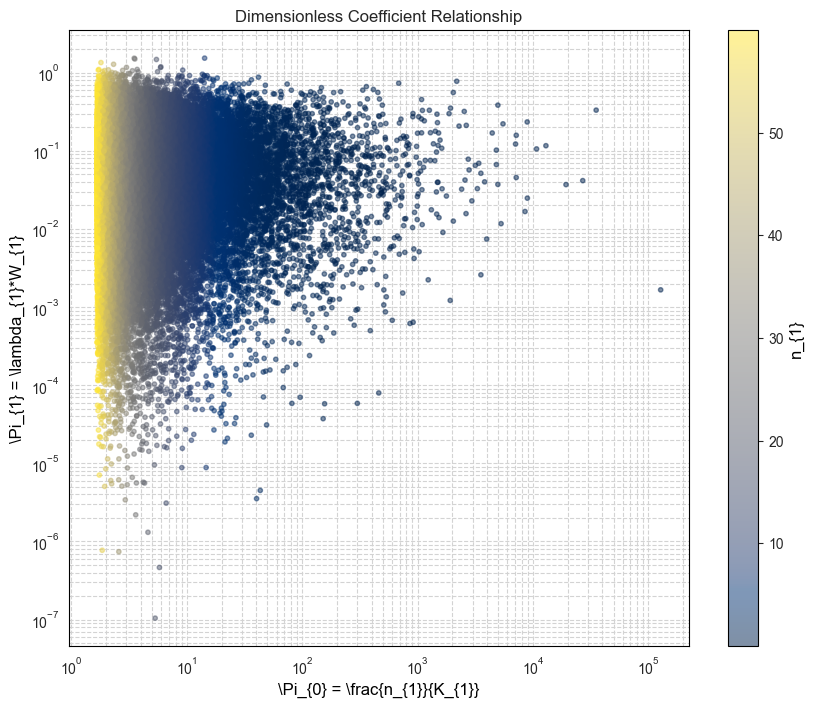

In [20]:
# Create a Moody-like dimensionless plot
# plt.figure(figsize=(10, 8))
plt.figure(figsize=(10, 8), facecolor="white")  # Set figure background to white
ax = plt.gca()
ax.set_facecolor("white") 

# Get first two coefficients for demonstration
pi_list = list(tas_mch._coefficients.keys())
print(pi_list)
pi_x = pi_list[0]  # First coefficient for x-axis
pi_y = pi_list[1]  # Second coefficient for y-axis

# Create scatter plot with color based on a third variable (e.g., third coefficient or input)
scatter = plt.scatter(
    df_results[pi_x],
    df_results[pi_y],
    # Color by one of the variables (adjust as needed)
    c=df_results["n_{1}_\\Pi_{0}"],
    alpha=0.5,
    s=10,
    cmap="cividis"
)

# Add color bar
plt.colorbar(scatter, label="n_{1}")

# Log scales often work well for dimensionless plots
plt.xscale("log")
plt.yscale("log")

# Labels and title
plt.xlabel(f"{pi_x} = {tas_mch._coefficients[pi_x].pi_expr}")
plt.ylabel(f"{pi_y} = {tas_mch._coefficients[pi_y].pi_expr}")
plt.title("Dimensionless Coefficient Relationship")
plt.grid(True, which="both", ls="--", alpha=1)  # Make grid lines more subtle


# Save the figure
plt.savefig("data/CS-1-HealthTAS/img/tas_dimensionless_chart.png",
            dpi=300, bbox_inches="tight", facecolor="white")
plt.show()

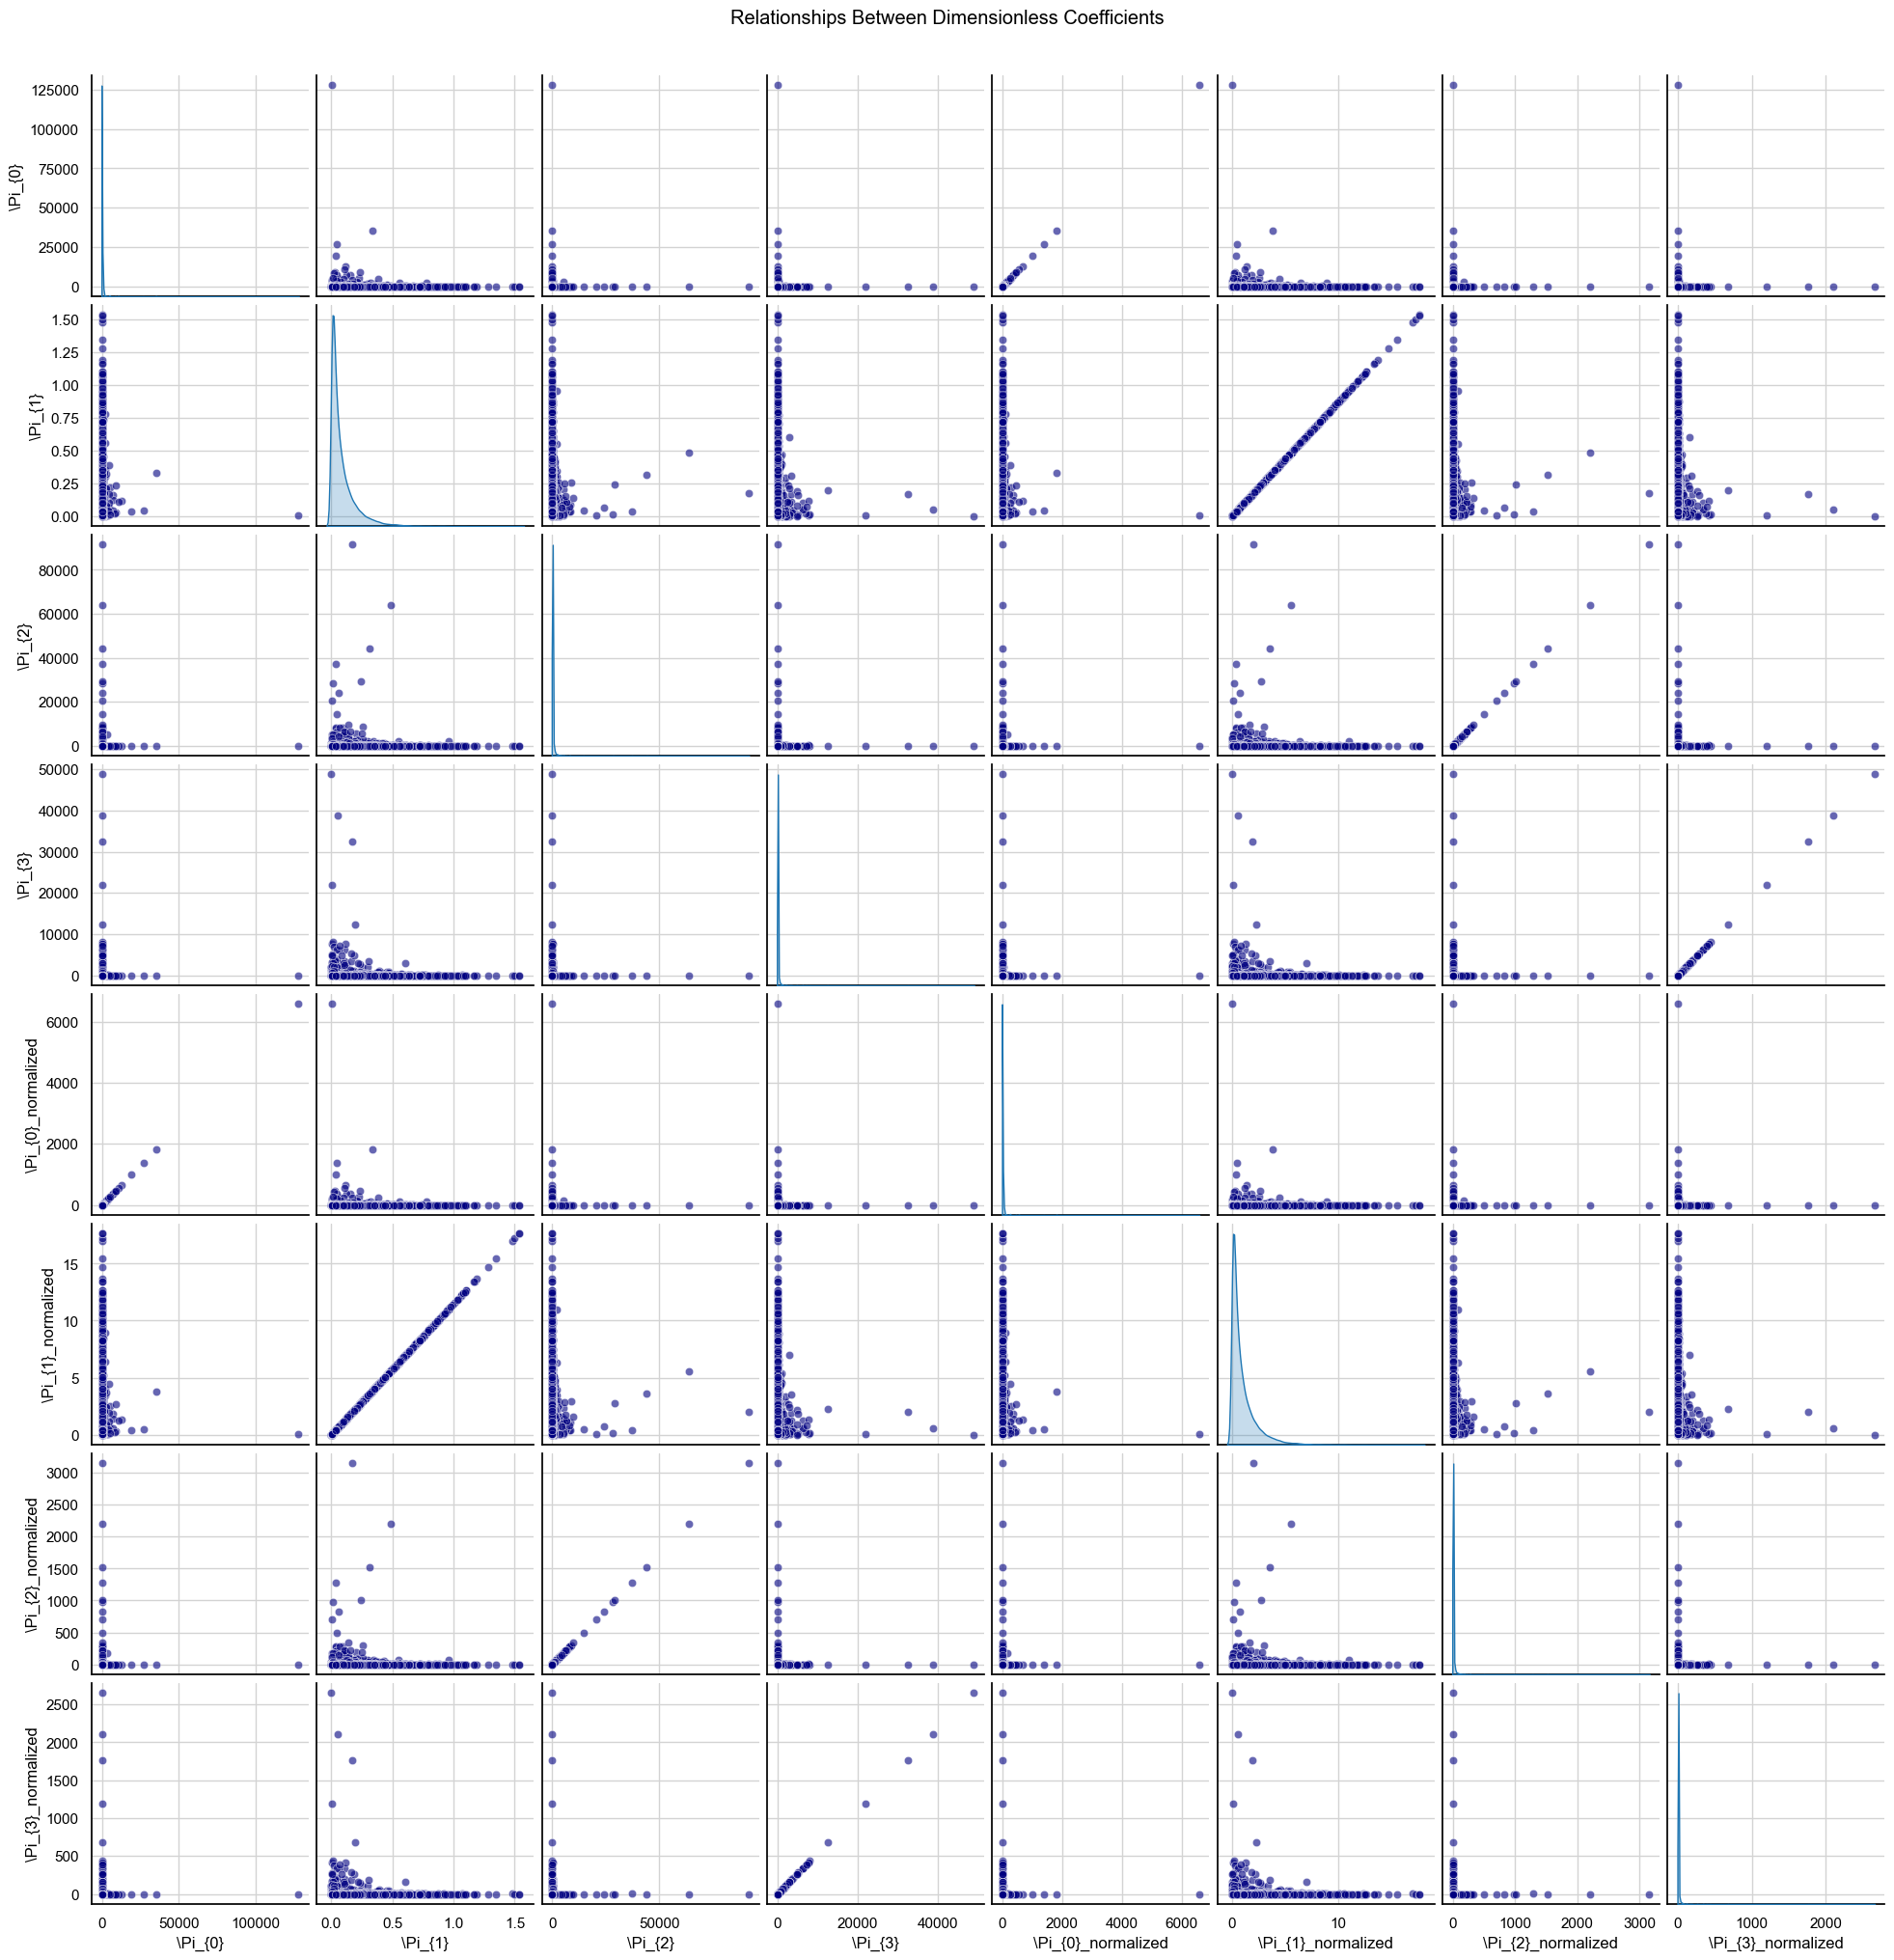

In [21]:
# Create a pairplot with white background and black text
sns.set_context("notebook", font_scale=1.0)

# Create a pairplot to see relationships between multiple coefficients
coef_columns = [col for col in df_results.columns if col.startswith("\\Pi")]
g = sns.pairplot(df_results[coef_columns], diag_kind="kde", height=2.5,
                 plot_kws={'alpha': 0.6, 'color': 'navy'})

# Set white background and black text for all subplots
for ax in g.axes.flatten():
    ax.set_facecolor('white')
    ax.tick_params(colors='black', which='both')
    for text in ax.texts:
        text.set_color('black')

# Set figure background and title
g.fig.patch.set_facecolor('white')
plt.suptitle("Relationships Between Dimensionless Coefficients",
             y=1.02, color='black')

# Save with white background
plt.savefig("data/CS-1-HealthTAS/img/tas_coefficient_relationships.png",
            dpi=500, bbox_inches='tight', facecolor='white')
plt.show()

In [22]:
df_results.columns.tolist()

['n_{1}_\\Pi_{0}',
 'K_{1}_\\Pi_{0}',
 '\\Pi_{0}',
 '\\lambda_{1}_\\Pi_{1}',
 'W_{1}_\\Pi_{1}',
 '\\Pi_{1}',
 '\\miu_{1}_\\Pi_{2}',
 '\\lambda_{1}_\\Pi_{2}',
 '\\Pi_{2}',
 'L_{1}_\\Pi_{3}',
 'K_{1}_\\Pi_{3}',
 '\\Pi_{3}',
 '\\Pi_{0}_normalized',
 '\\Pi_{1}_normalized',
 '\\Pi_{2}_normalized',
 '\\Pi_{3}_normalized']

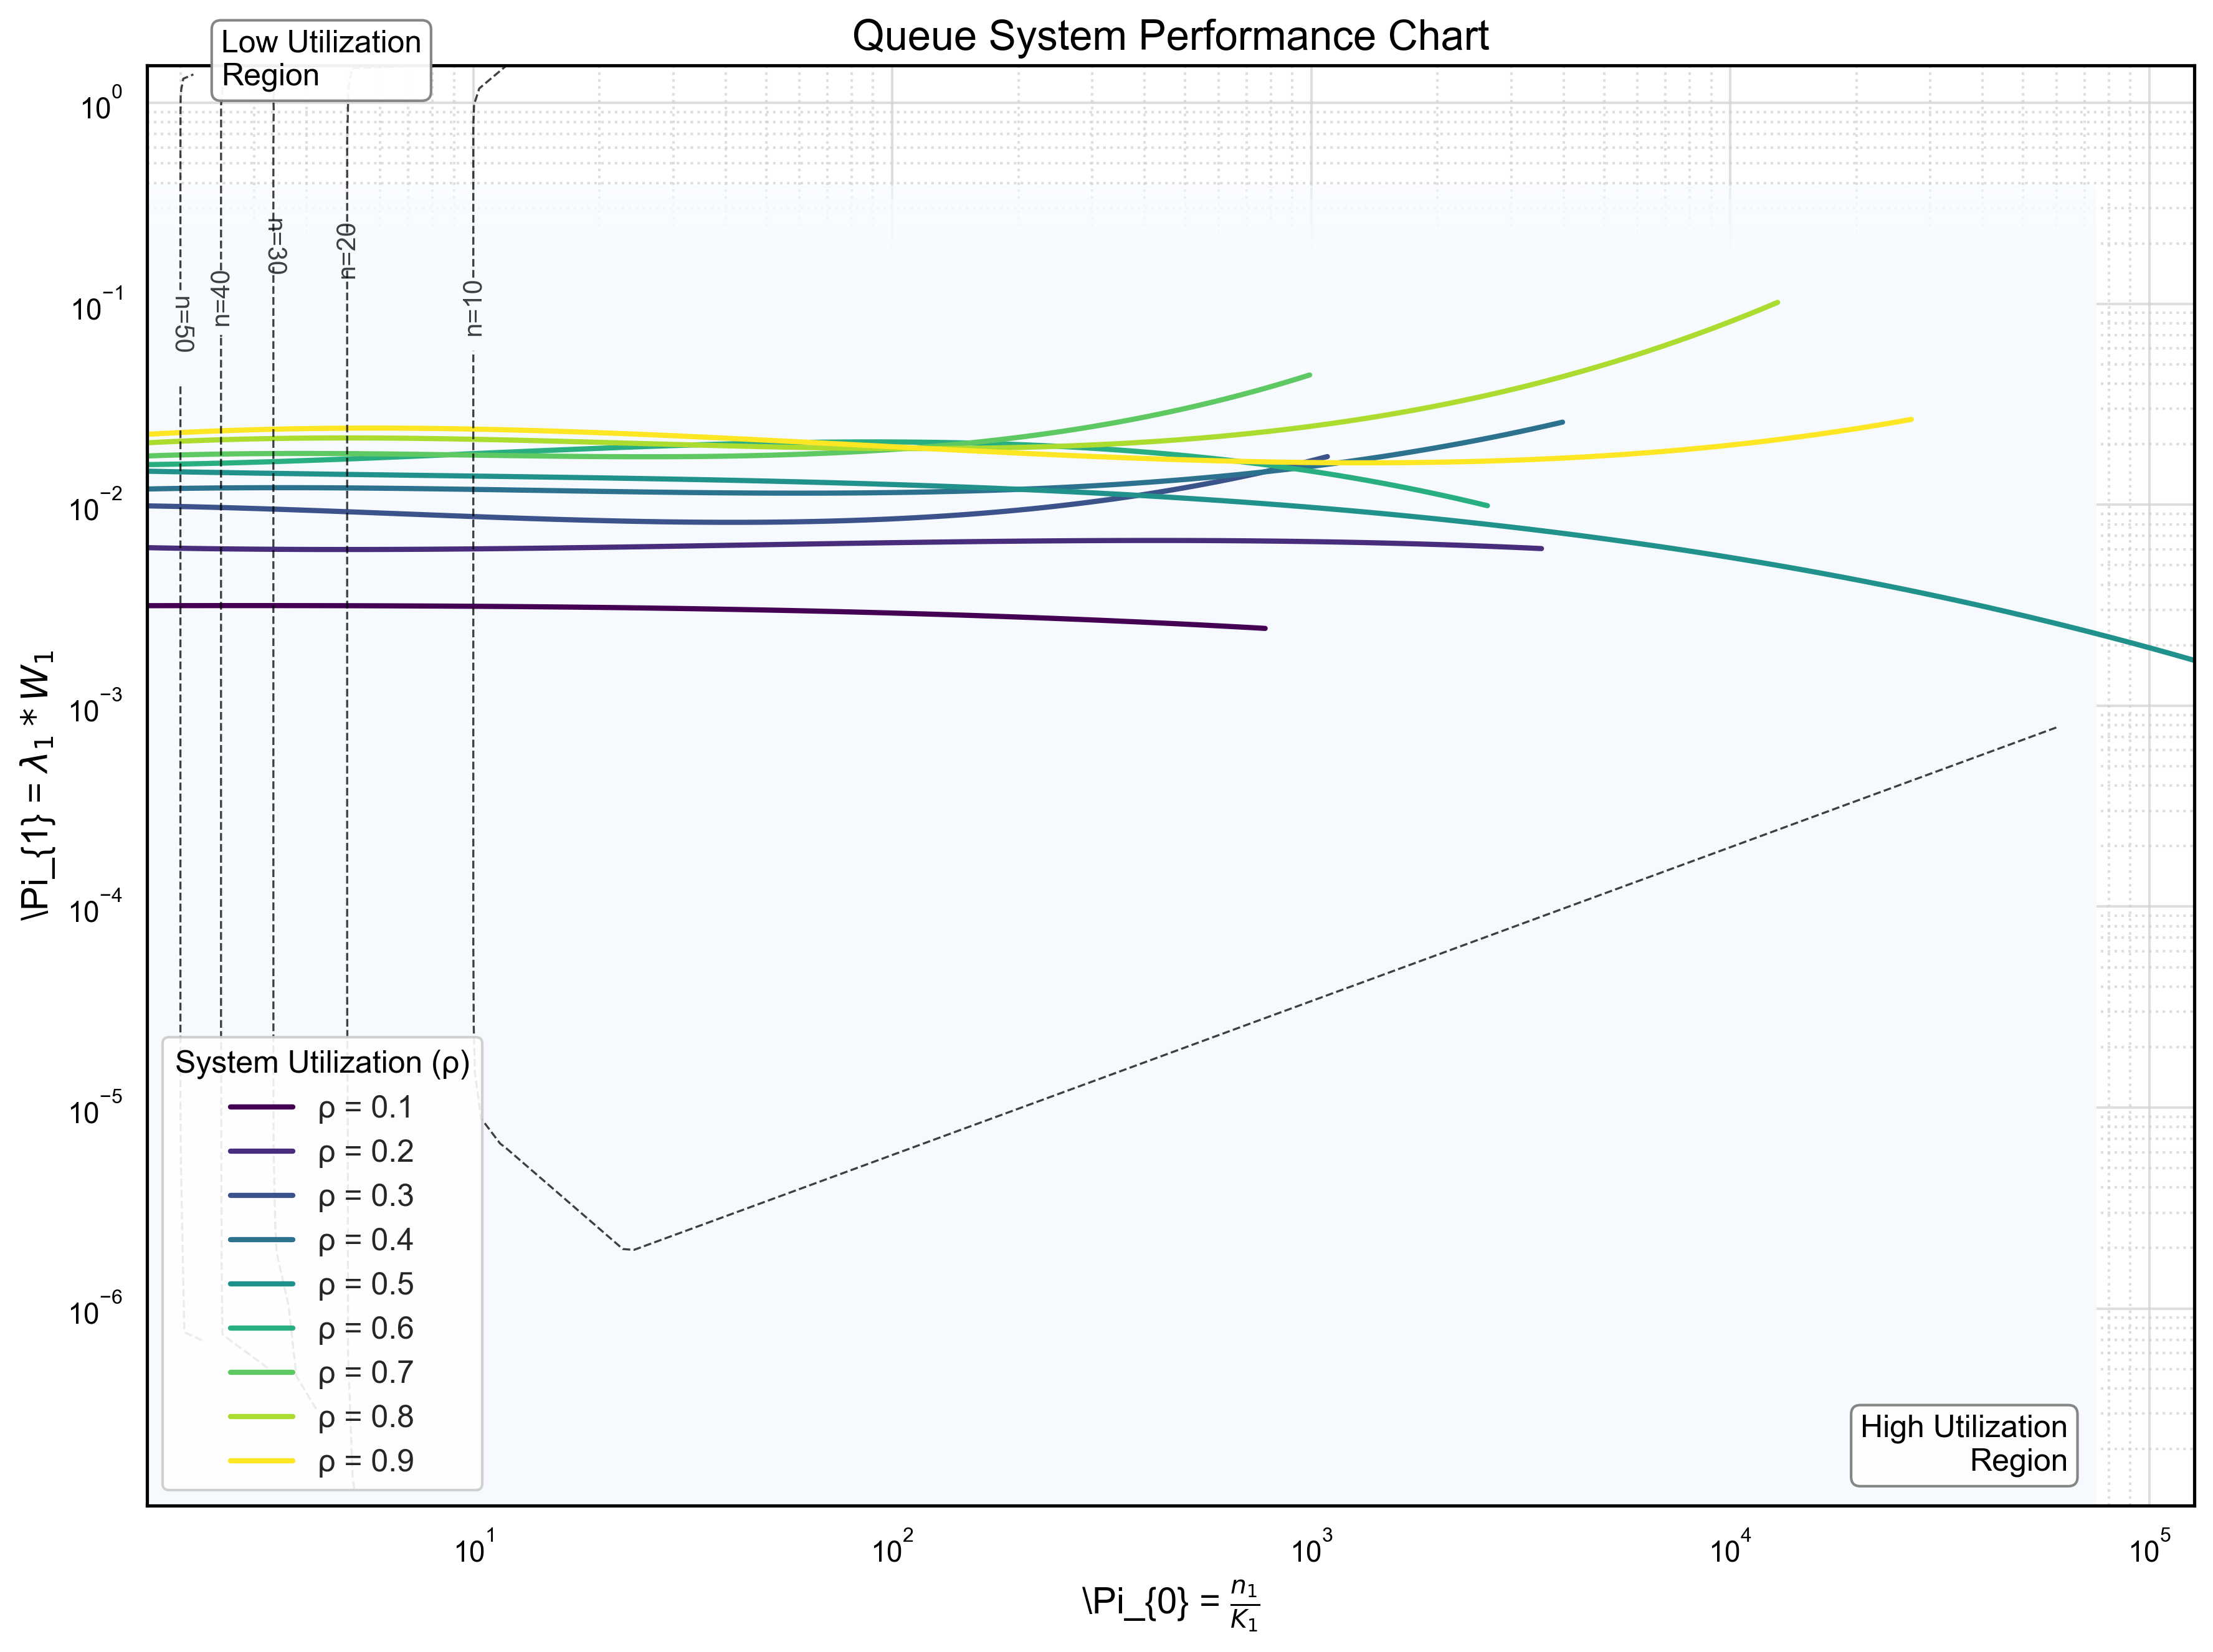

In [26]:
# Create directories if they dont exist
os.makedirs("data/CS-1-HealthTAS/img", exist_ok=True)

# Figure setup with appropriate size, resolution and white background
fig, ax = plt.subplots(figsize=(12, 9), dpi=300, facecolor="white")
ax.set_facecolor("white")

# Get first two coefficients for the plot axes
pi_list = list(tas_mch._coefficients.keys())
pi_x = pi_list[0]  # First coefficient for x-axis
pi_y = pi_list[1]  # Second coefficient for y-axis

# Calculate utilization ratio (common in queueing theory)
df_results["utilization"] = df_results["\\lambda_{1}_\\Pi_{1}"] / \
    df_results["\\miu_{1}_\\Pi_{2}"]

# Group data by utilization ratio to create characteristic curves
utilization_ranges = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
colors = plt.cm.viridis(np.linspace(0, 1, len(utilization_ranges)))

# Add hexbin background to show data density (like Moody chart)
hb = plt.hexbin(
    df_results[pi_x],
    df_results[pi_y],
    gridsize=40,
    cmap="Blues",
    alpha=0.60,
    mincnt=1
)

# Plot characteristic curves for different utilization ranges
for i, util in enumerate(utilization_ranges):
    # Filter data near this utilization value
    mask = (df_results["utilization"] >= util - 0.05) & \
           (df_results["utilization"] <= util + 0.05)
    subset = df_results[mask]

    if len(subset) > 10:  # Only draw if we have enough points
        # Sort by x-value for smooth curves
        subset = subset.sort_values(by=pi_x)

        # Create a polynomial fit (3rd degree works well for most curves)
        if len(subset) > 5:
            z = np.polyfit(np.log10(subset[pi_x]), np.log10(subset[pi_y]), 3)
            p = np.poly1d(z)

            # Create smooth x values for the line
            x_smooth = np.logspace(
                np.log10(subset[pi_x].min()),
                np.log10(subset[pi_x].max()),
                100
            )

            # Calculate predicted y values (convert back from log space)
            y_smooth = 10**p(np.log10(x_smooth))

            # Plot the trend line
            plt.plot(
                x_smooth,
                y_smooth,
                "-",
                linewidth=2,
                color=colors[i],
                label=f"ρ = {util:.1f}"
            )

# Add contour lines for queue length
queue_length_values = [10, 20, 30, 40, 50, 60, 70]
contour = plt.tricontour(
    df_results[pi_x],
    df_results[pi_y],
    df_results["n_{1}_\\Pi_{0}"],
    levels=queue_length_values,
    colors="black",
    linestyles="dashed",
    linewidths=0.8,
    alpha=0.75
)

# Add contour labels in black
plt.clabel(contour, inline=True, fontsize=10, fmt="n=%1.0f", colors="black")

# Set up log scales (standard for Moody-like charts)
plt.xscale("log")
plt.yscale("log")

# Add grid with minor lines - lighter color for better visibility on white background
plt.grid(True, which="both", ls="-", color="lightgray", alpha=0.75)
plt.grid(True, which="minor", ls=":", color="lightgray", alpha=0.75)
plt.minorticks_on()

# Format tick labels for better readability
formatter = ticker.LogFormatterMathtext(base=10)
plt.gca().xaxis.set_major_formatter(formatter)
plt.gca().yaxis.set_major_formatter(formatter)

# Make sure ticks and labels are black
ax.tick_params(axis="both", colors="black")

# Add descriptive labels and title in black
plt.xlabel(
    f"{pi_x} = ${tas_mch._coefficients[pi_x].pi_expr}$", fontsize=14, color="black")
plt.ylabel(
    f"{pi_y} = ${tas_mch._coefficients[pi_y].pi_expr}$", fontsize=14, color="black")
plt.title("Queue System Performance Chart", fontsize=16, color="black")

# Add legend with clear styling
legend = plt.legend(
    title="System Utilization (ρ)",
    loc="best",
    fontsize=12,
    framealpha=0.9
)
legend.get_title().set_color("black")

# Add annotations for regions with better visibility on white background
plt.text(
    df_results[pi_x].min()*1.5,
    df_results[pi_y].max()*0.8,
    "Low Utilization\nRegion",
    fontsize=12,
    ha="left",
    color="black",
    bbox=dict(facecolor="white", alpha=0.95, boxstyle="round", edgecolor="gray")
)

plt.text(
    df_results[pi_x].max()*0.5,
    df_results[pi_y].min()*1.5,
    "High Utilization\nRegion",
    fontsize=12,
    ha="right",
    color="black",
    bbox=dict(facecolor="white", alpha=0.95, boxstyle="round", edgecolor="gray")
)

# Save and display with white background
plt.tight_layout()
plt.savefig("data/CS-1-HealthTAS/img/tas_behaviour_chart.png",
            dpi=300, bbox_inches="tight", facecolor="white")
plt.show()

### **Arternative Design No.1 (Horizontal Scaling)**

#### **Dimensional Variables**

#### **Dimensionless Coefficients**

#### **Sensitivity Analysis**

#### **Monte Carlo Simulation**

### **Arternative Design No.2 (Vertical Scaling)**

#### **Dimensional Variables**

#### **Dimensionless Coefficients**

#### **Sensitivity Analysis**

#### **Monte Carlo Simulation**

## **Conclusion**

## **Future Work**